In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import scipy.ndimage as ndi

from pathlib import Path
import shutil

from src.data.paths import project_dir
from src.data.analysis import read_tiff_img, Circle, create_circular_mask
from src.data.detector import DetectorDataCollection, DetectorData, DetectorImage

# Data loading

## Paths

In [2]:
# local paths
#base_path = project_dir / 'data' / 'raw'
base_path = Path.home() / 'OneDrive - ifj.edu.pl' / 'Projects' / 'MB_foils'

base_path.exists()

True

In [3]:
proton_path = base_path / '2025-03-27' / 'PB'
proton_path.exists()

True

In [4]:
co60_path = base_path / '2025-03-18'
co60_path.exists()

True

In [5]:
bg_path = base_path / '2025-03-27' / 'tlo2'
bg_path.exists()

True

In [6]:
base_output_path =  base_path / '2025_march_experiment' / 'analysis' / 'interim' / '2025-03-27'  # OneDrive

proton_output_path = base_output_path / 'protons'
co60_output_path = base_output_path / 'Co60'
bg_output_path = base_output_path / 'background'

# remove base output path
shutil.rmtree(base_output_path, ignore_errors=True)

# create output paths
proton_output_path.mkdir(parents=True, exist_ok=True)
co60_output_path.mkdir(parents=True, exist_ok=True)
bg_output_path.mkdir(parents=True, exist_ok=True)

print(f"created {proton_output_path}")

created C:\Users\Legion\OneDrive - ifj.edu.pl\Projects\MB_foils\2025_march_experiment\analysis\interim\2025-03-27\protons


## Data structures

In [7]:
proton_raw_data = DetectorDataCollection(path=proton_path)

10 11 12 13 14 15 16 17 18 19 1 20 21 22 23 24 25 26 27 28 29 2 30 31 32 33 34 35 36 37 38 39 3 40 4 5 6 7 8 9 

In [8]:

co60_raw_data = DetectorDataCollection(path=co60_path)

85 86 87 88 89 

In [9]:
bg_raw_det_path = next(bg_path.glob('**/*tif'))
bg_raw_det_image = DetectorImage(path=bg_raw_det_path, image=read_tiff_img(bg_raw_det_path, border_px=0))
bg_lv_det_path = next(bg_path.with_name(bg_path.name + '_lv').glob('**/*tif'))
bg_lv_det_image = DetectorImage(path=bg_lv_det_path, image=read_tiff_img(bg_lv_det_path, border_px=0))
bg_det_data = DetectorData(raw=bg_raw_det_image, lv=bg_lv_det_image, det_no=-1)

bg_raw_data = DetectorDataCollection(path=bg_path, data={-1: bg_det_data})

# Proton raw data

In [10]:
proton_det_id = list(proton_raw_data.data.keys())[0]
proton_det_id

10

In [11]:
def plot_lv_raw_and_histograms(
        lv_image: np.ndarray,
        raw_data: np.ndarray,
        title: str = None,
        clip_percentile: float = 99,
        strip_width: int = 100,
        gaussian_kernel_size: int = 3,
        n_sigma : int = 3,
        probe_radius: float = 10,
):
        # Define the colors for the colormap
        colors = [(0, 1, 0), (1, 0, 0)]  # green -> red
        cmap_name = 'custom_cmap'
        custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

        # Set NaN values to white
        custom_cmap.set_bad(color='white')

        # lv_image = proton_raw_data.data[proton_det_id].lv.image.copy()
        lv_image_strip = np.concatenate([
                lv_image[:, :strip_width].flatten(), 
                lv_image[:, -strip_width:].flatten(),
                lv_image[:strip_width, :].flatten(),
                lv_image[-strip_width:, :].flatten()
        ]).flatten()

        lv_mean_noise = np.mean(lv_image_strip)
        lv_sigma_noise = np.std(lv_image_strip)
        lv_upper_limit = np.percentile(lv_image, clip_percentile)


        lv_smoothed_image = ndi.gaussian_filter(lv_image, sigma=gaussian_kernel_size).astype(np.float32)

        detector_mask = lv_smoothed_image > lv_mean_noise + n_sigma * lv_sigma_noise

        lv_smoothed_image[~detector_mask] = 0

        lv_smoothed_image = lv_smoothed_image[300:700, 300:700]

        lv_cm = ndi.center_of_mass(lv_smoothed_image)

        lv_cm_mask = create_circular_mask(lv_smoothed_image, Circle(x=lv_cm[1], y=lv_cm[0], r=probe_radius))

        lv_circle_upper_limit = np.nanmean(lv_smoothed_image[lv_cm_mask].flatten()) + n_sigma * np.nanstd(lv_smoothed_image[lv_cm_mask].flatten())
        lv_circle_lower_limit = np.nanmean(lv_smoothed_image[lv_cm_mask].flatten()) - n_sigma * np.nanstd(lv_smoothed_image[lv_cm_mask].flatten())

        lv_smoothed_image[lv_smoothed_image < lv_circle_lower_limit] = np.nan
        lv_smoothed_image[lv_smoothed_image > lv_circle_upper_limit] = np.nan

        raw_image_strip = np.concatenate([
                raw_data[:, :strip_width].flatten(),
                raw_data[:, -strip_width:].flatten(),
                raw_data[:strip_width, :].flatten(),
                raw_data[-strip_width:, :].flatten()
        ]).flatten()

        raw_mean_noise = np.mean(raw_image_strip)
        raw_sigma_noise = np.std(raw_image_strip)
        raw_upper_limit = np.percentile(raw_data, clip_percentile)

        raw_smoothed_image = ndi.gaussian_filter(raw_data, sigma=gaussian_kernel_size).astype(np.float32)
        raw_smoothed_image[~detector_mask] = 0

        raw_smoothed_image = raw_smoothed_image[300:700, 300:700]

        raw_cm = ndi.center_of_mass(raw_smoothed_image)

        raw_cm_mask = create_circular_mask(raw_smoothed_image, Circle(x=raw_cm[1], y=raw_cm[0], r=probe_radius))

        raw_circle_upper_limit = np.mean(raw_smoothed_image[raw_cm_mask].flatten()) + n_sigma * np.std(raw_smoothed_image[raw_cm_mask].flatten())
        raw_circle_lower_limit = np.mean(raw_smoothed_image[raw_cm_mask].flatten()) - n_sigma * np.std(raw_smoothed_image[raw_cm_mask].flatten())

        raw_cm_mask = create_circular_mask(raw_smoothed_image, Circle(x=raw_cm[1], y=raw_cm[0], r=probe_radius))

        raw_smoothed_image[raw_smoothed_image < raw_circle_lower_limit] = np.nan
        raw_smoothed_image[raw_smoothed_image > raw_circle_upper_limit] = np.nan

        fig, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0,0].hist(lv_image.flatten(), 
                bins=100, 
                range=(0, lv_upper_limit),
                density=True,
                histtype='step',
                label='all data');
        ax[0,0].axvline(lv_mean_noise, color='r', linestyle='--', label='mean noise')
        ax[0,0].axvline(lv_mean_noise + n_sigma * lv_sigma_noise, color='g', linestyle='--', label=f'mean noise + {n_sigma} sigma')
        ax[0,0].hist(lv_smoothed_image[lv_cm_mask].flatten(),
                bins=100, 
                range=(0, lv_upper_limit),
                density=True,
                histtype='step',
                color='blue',
                label='blue circle mask data (smoothed)');
        ax[0,0].set_yscale('log')
        ax[0,0].legend()
        ax[0,0].grid()
        ax[0,0].set_xlim(0, None)

        ax[1,0].hist(raw_data.flatten(),
                bins=100, 
                range=(0, raw_upper_limit),
                density=True,
                histtype='step',
                label='all data');
        ax[1,0].axvline(raw_mean_noise, color='r', linestyle='--', label='mean noise')
        ax[1,0].axvline(raw_mean_noise + n_sigma * raw_sigma_noise, color='g', linestyle='--', label=f'mean noise + {n_sigma} sigma')
        ax[1,0].hist(raw_smoothed_image[raw_cm_mask].flatten(),
                bins=100, 
                range=(0, raw_upper_limit),
                density=True,
                histtype='step',
                color='blue',
                label='blue circle mask data (smoothed)');
        ax[1,0].set_yscale('log')
        ax[1,0].legend()
        ax[1,0].grid()
        ax[1,0].set_xlim(0, None)


        pos = ax[0,1].imshow(lv_smoothed_image, 
                        cmap=custom_cmap, 
                        vmin=lv_circle_lower_limit,
                        vmax=lv_circle_upper_limit)
        ax[0,1].grid()
        plt.colorbar(pos, ax=ax[0,1], shrink=0.8, pad=0.01)
        ax[0,1].set_title('lv image')

        ax[0,1].scatter(lv_cm[1], lv_cm[0], color='blue', s=10, label='center of mass')
        ax[0,1].add_patch(
                plt.Circle(
                        (lv_cm[1], lv_cm[0]), 
                        probe_radius, 
                        color='blue', 
                        fill=False, 
                )
        )
        
        pos = ax[1,1].imshow(raw_smoothed_image,
                        cmap=custom_cmap, 
                        vmin=raw_circle_lower_limit, 
                        vmax=raw_circle_upper_limit)
        ax[1,1].grid()
        plt.colorbar(pos, ax=ax[1,1], shrink=0.8, pad=0.01)
        ax[1,1].set_title('raw image')
        ax[1,1].scatter(raw_cm[1], raw_cm[0], color='blue', s=10, label='center of mass')
        ax[1,1].add_patch(
                plt.Circle(
                        (raw_cm[1], raw_cm[0]), 
                        probe_radius, 
                        color='blue', 
                        fill=False, 
                )
        )
        

        fig.suptitle(title, fontsize=16)

        fig.tight_layout();

        plt.show()
        plt.close(fig)

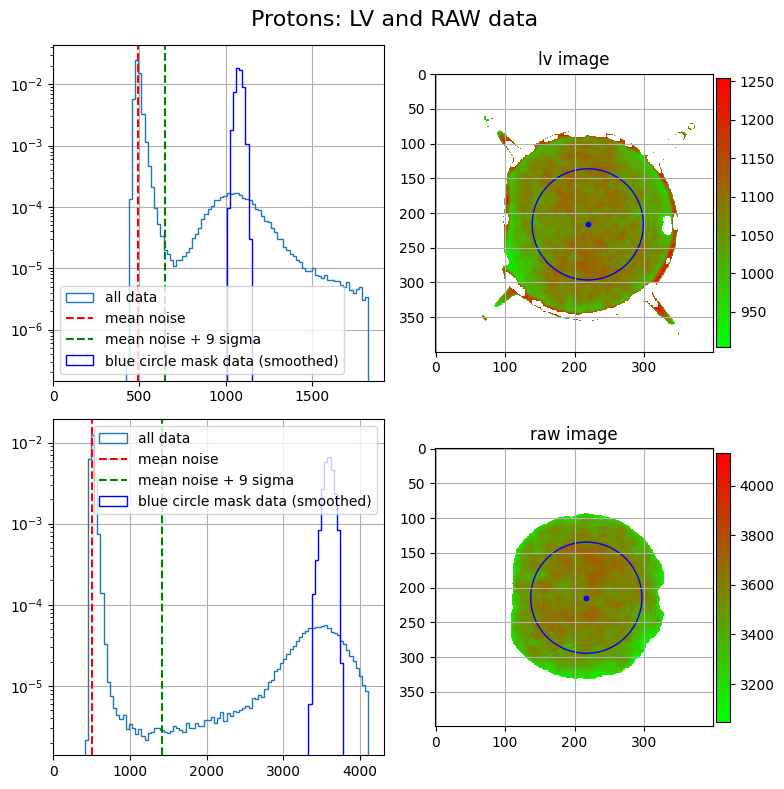

In [12]:
plot_lv_raw_and_histograms(
        lv_image=proton_raw_data.data[proton_det_id].lv.image.copy(),
        raw_data=proton_raw_data.data[proton_det_id].raw.image.copy(),
        title='Protons: LV and RAW data',
        probe_radius=80,
        gaussian_kernel_size=3,
        n_sigma=9,
        clip_percentile=99.9,
)

# Background data

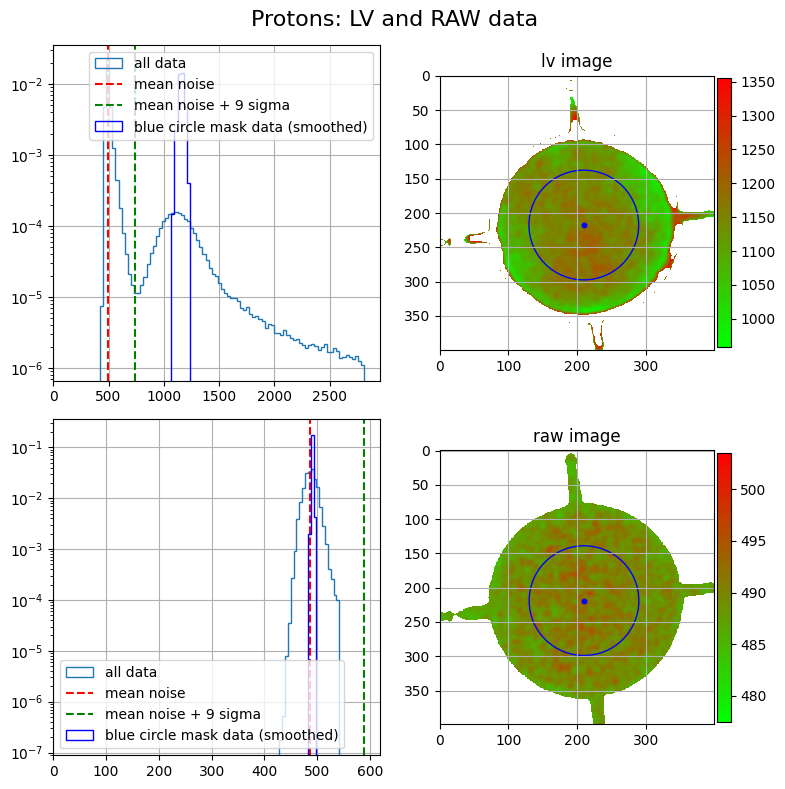

In [13]:
plot_lv_raw_and_histograms(
        lv_image=bg_det_data.lv.image.copy(),
        raw_data=bg_det_data.raw.image.copy(),
        title='Protons: LV and RAW data',
        probe_radius=80,
        gaussian_kernel_size=3,
        n_sigma=9,
        clip_percentile=99.9,
)

# Co60 data

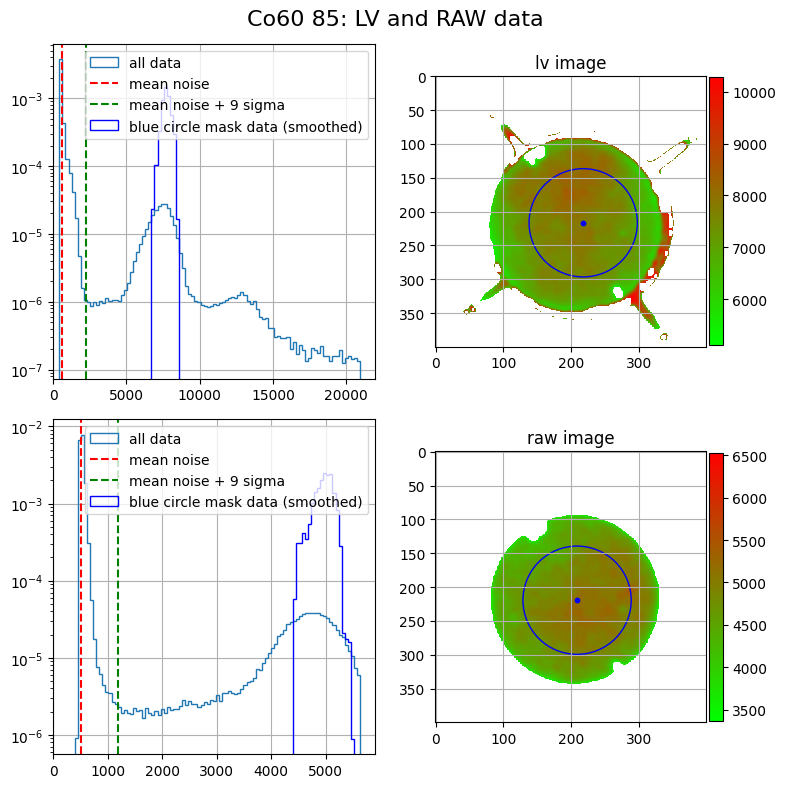

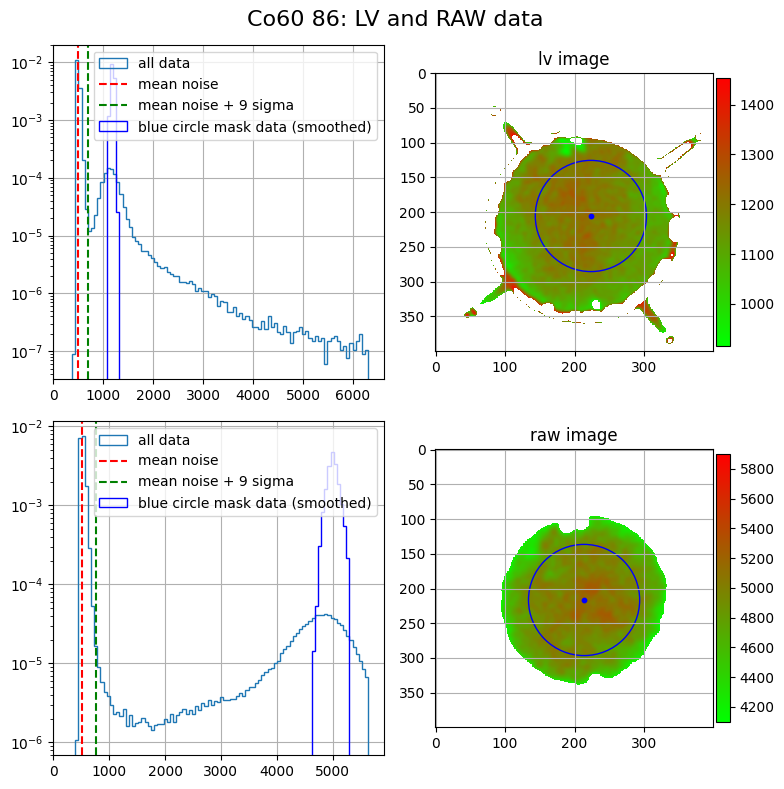

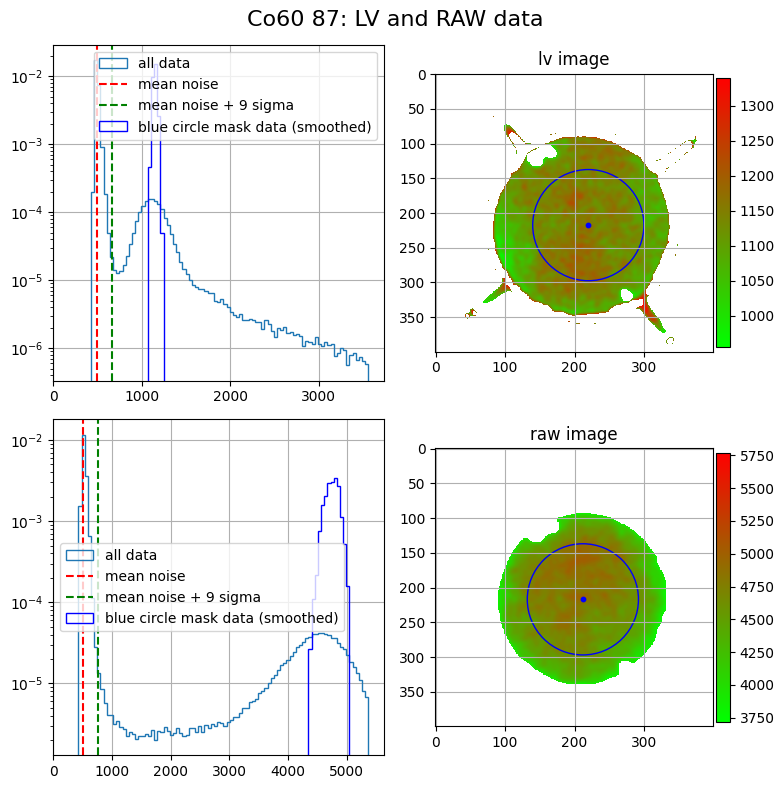

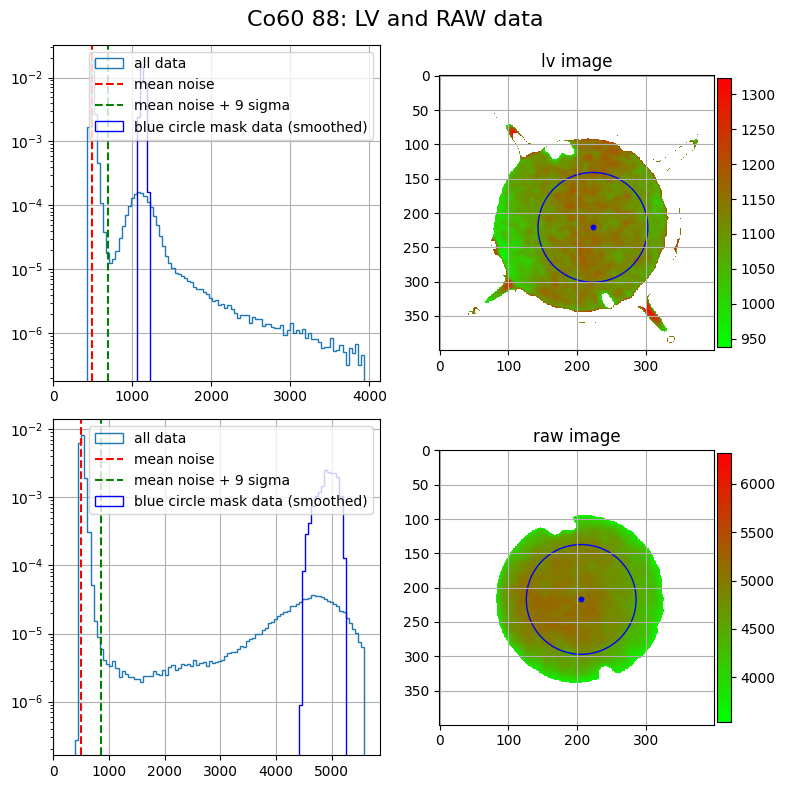

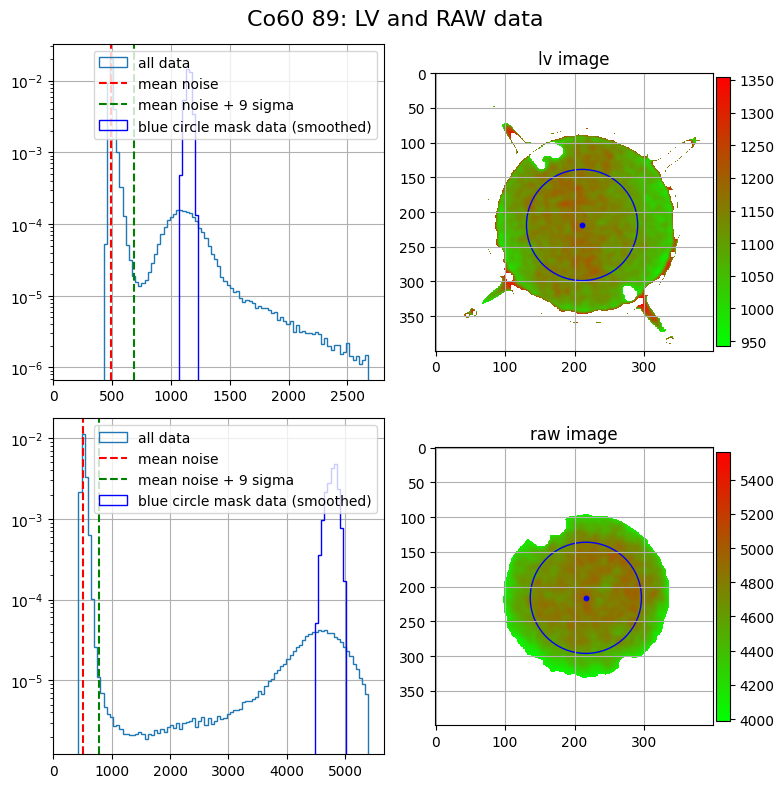

In [14]:
for co60_det_id in sorted(co60_raw_data.data.keys()):
    plot_lv_raw_and_histograms(
        lv_image=co60_raw_data.data[co60_det_id].lv.image.copy(),
        raw_data=co60_raw_data.data[co60_det_id].raw.image.copy(),
        title=f'Co60 {co60_det_id}: LV and RAW data',
        probe_radius=80,
        gaussian_kernel_size=3,
        n_sigma=9,
        clip_percentile=99.9,
    )

# Proton data

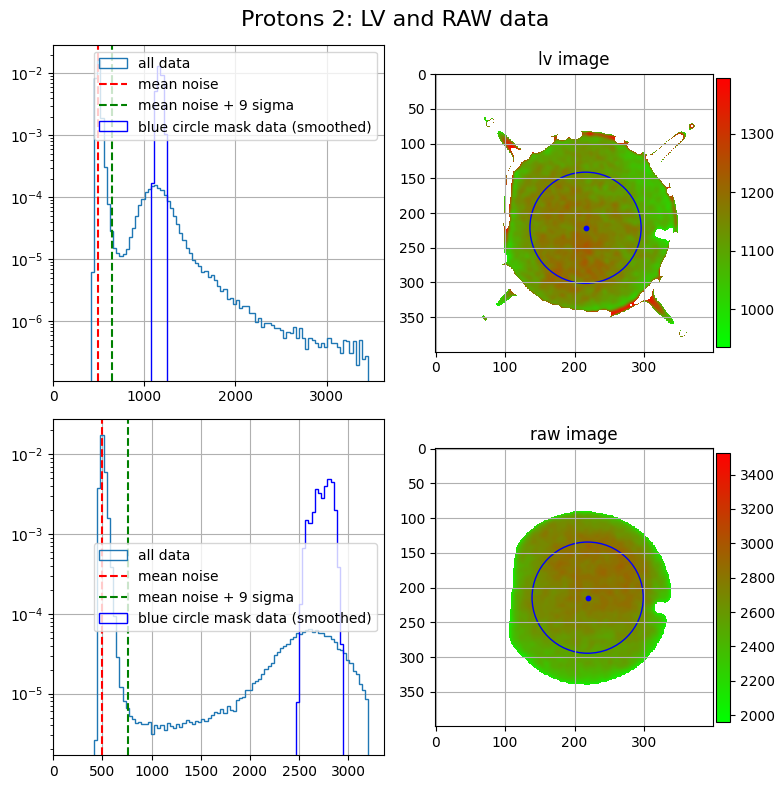

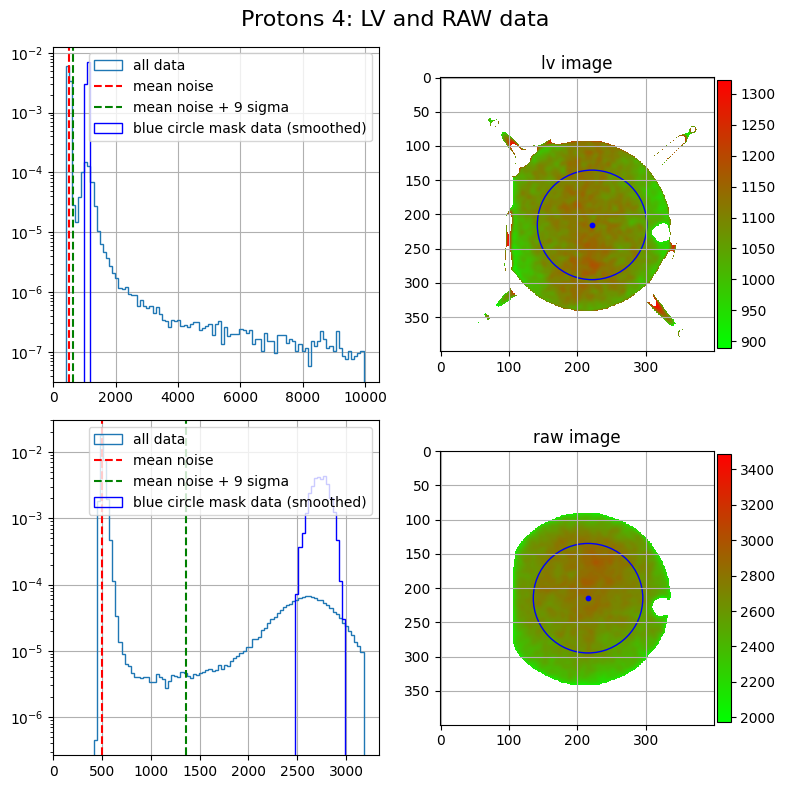

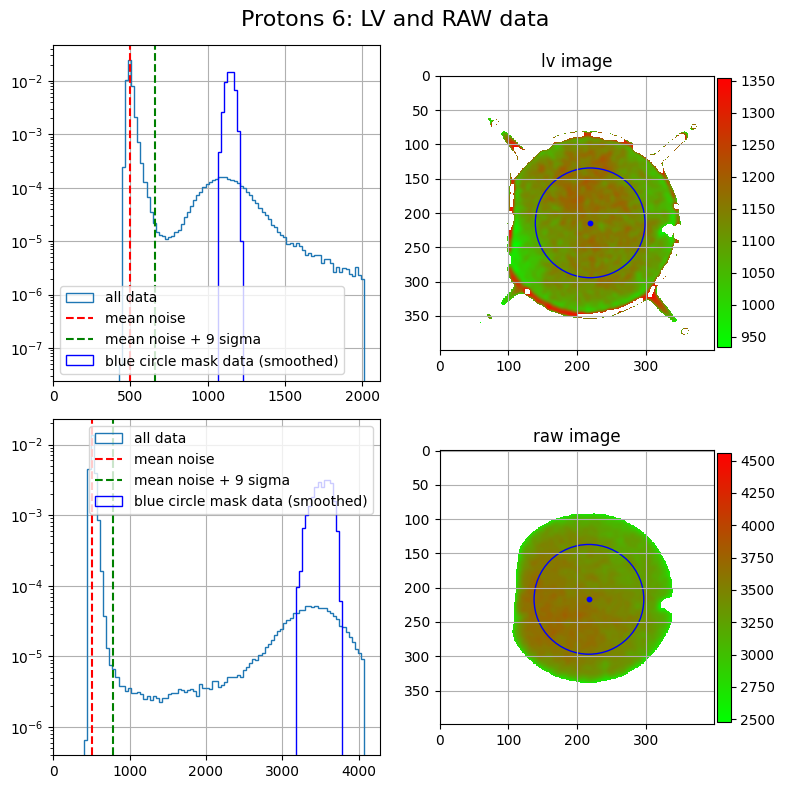

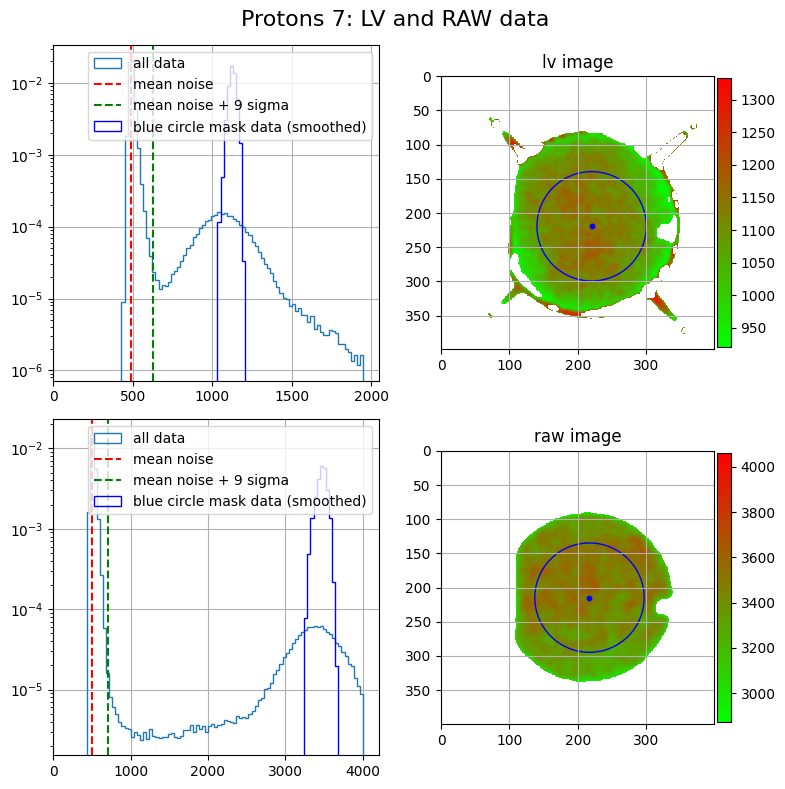

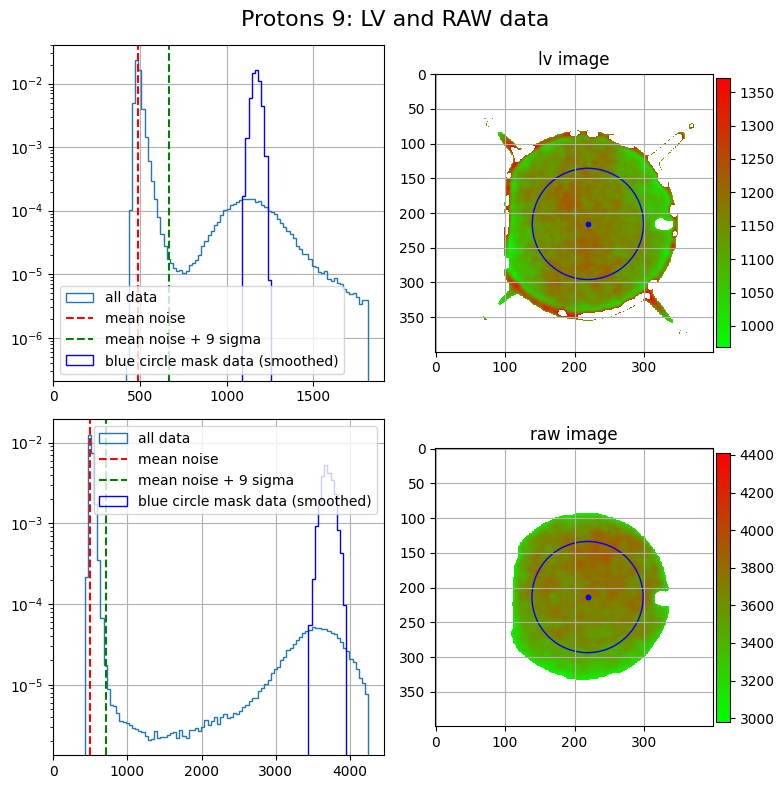

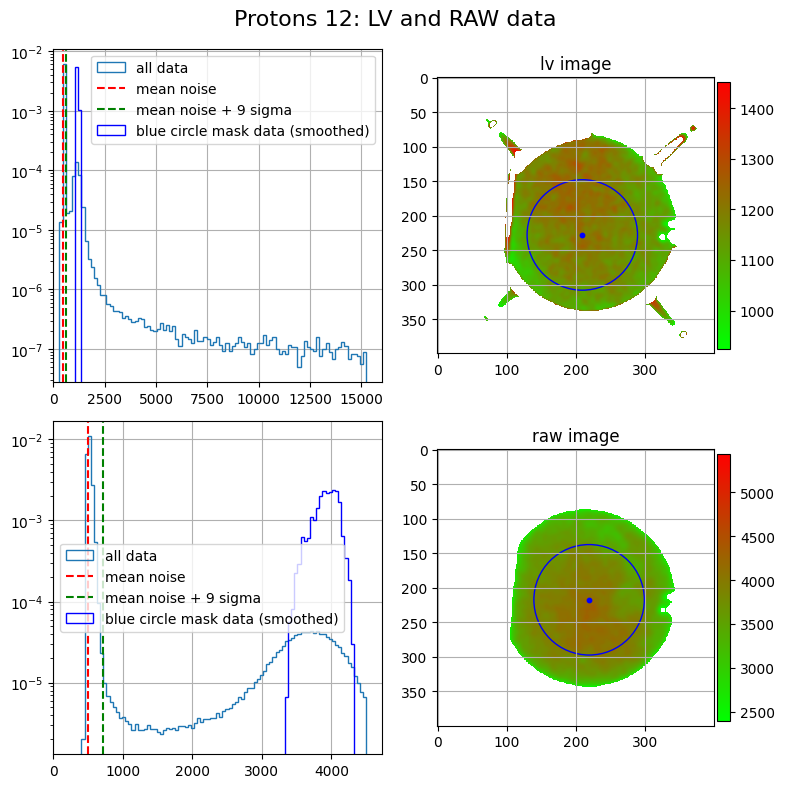

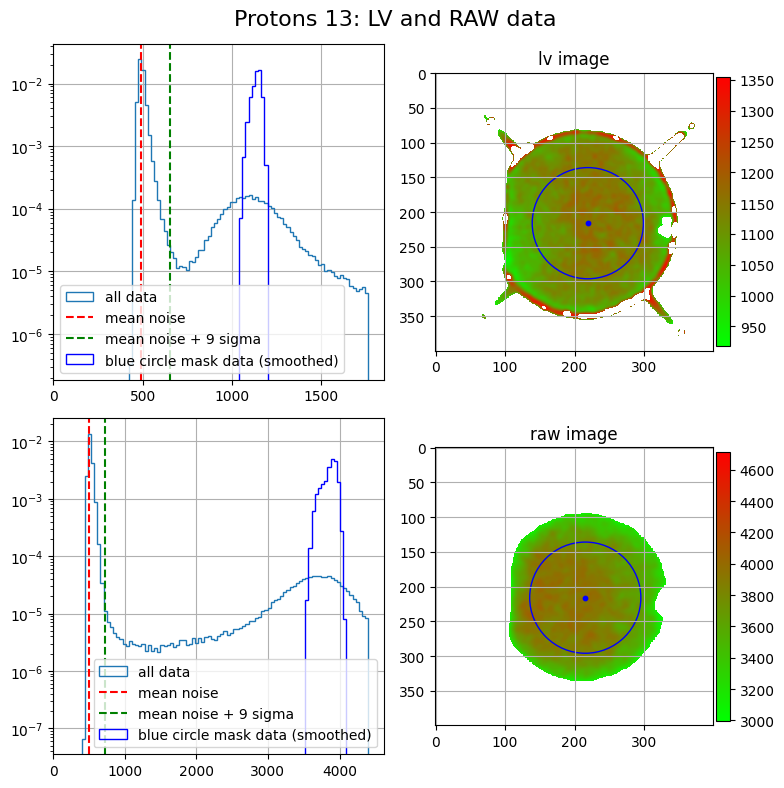

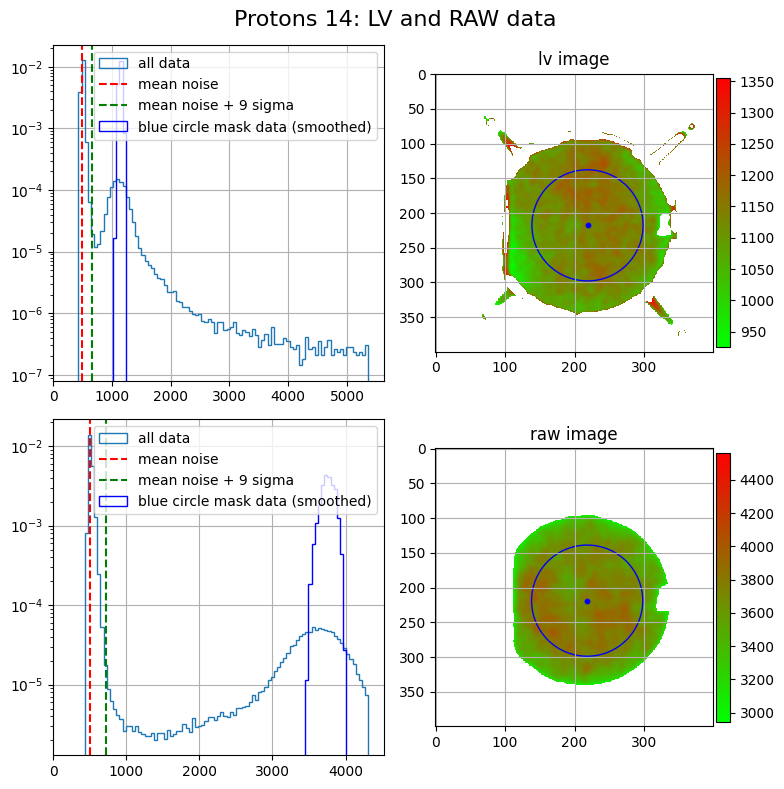

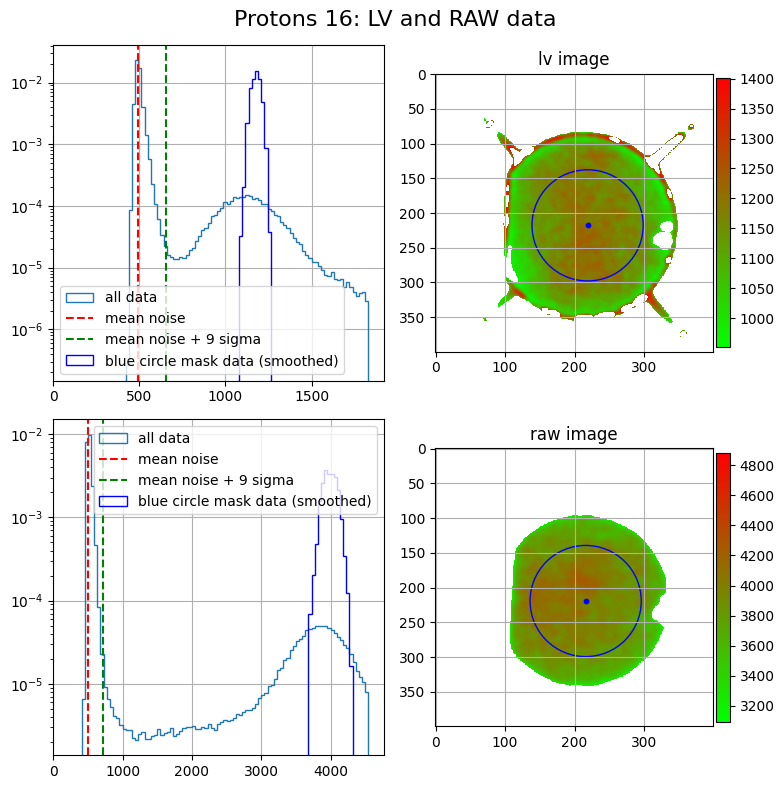

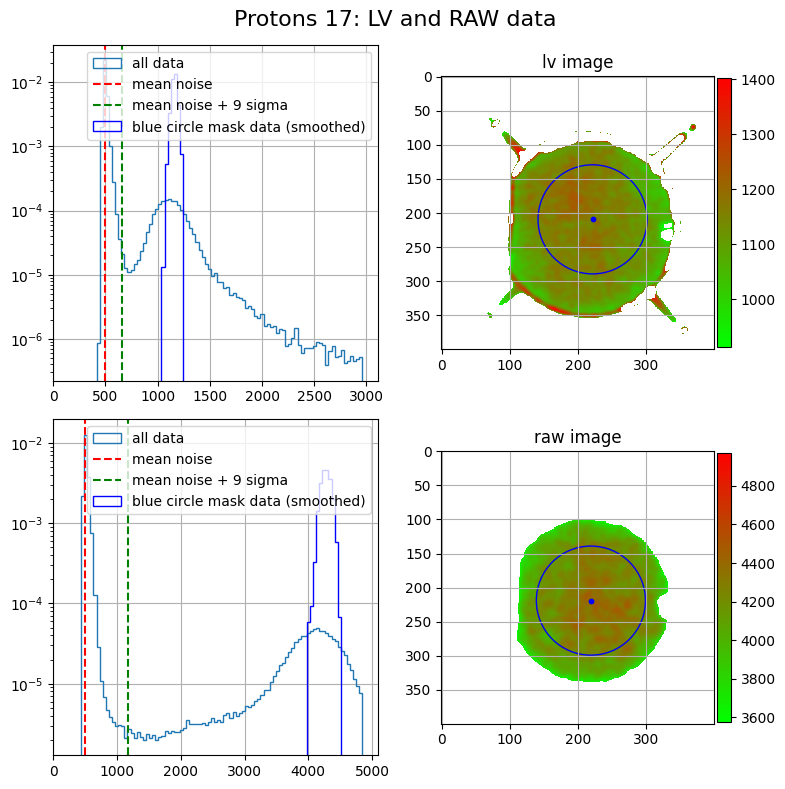

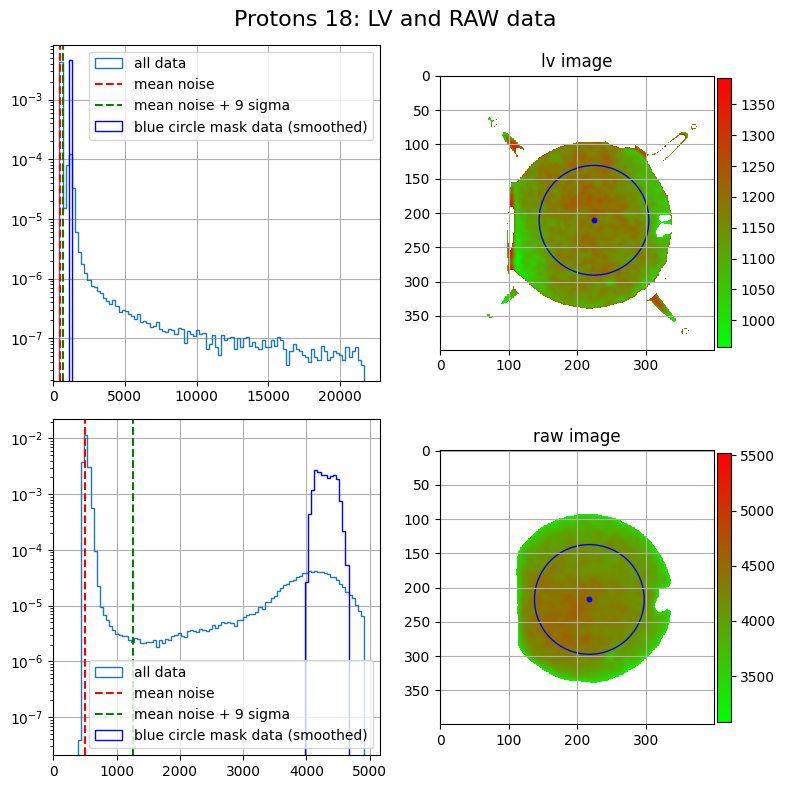

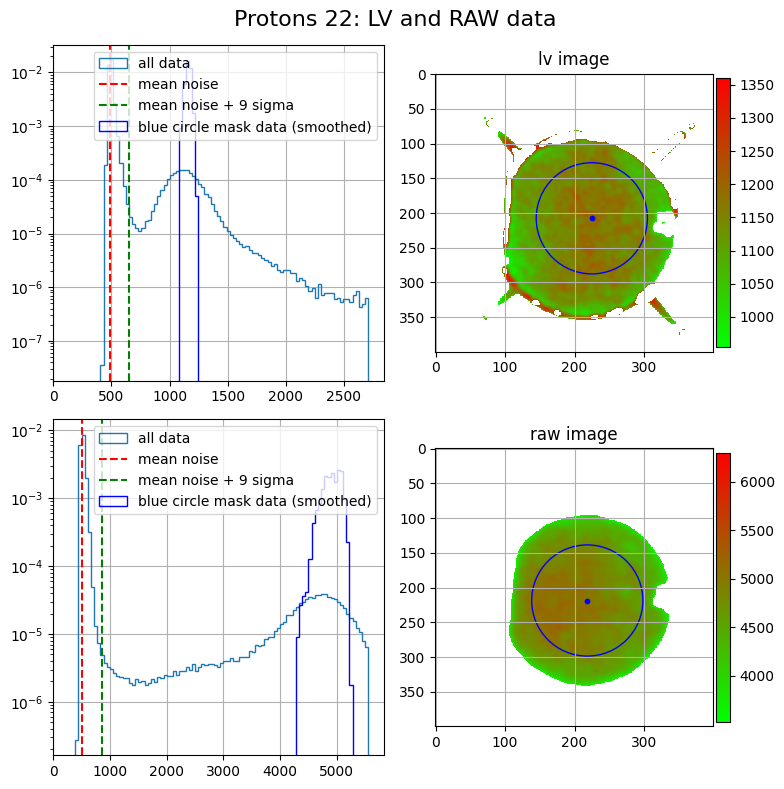

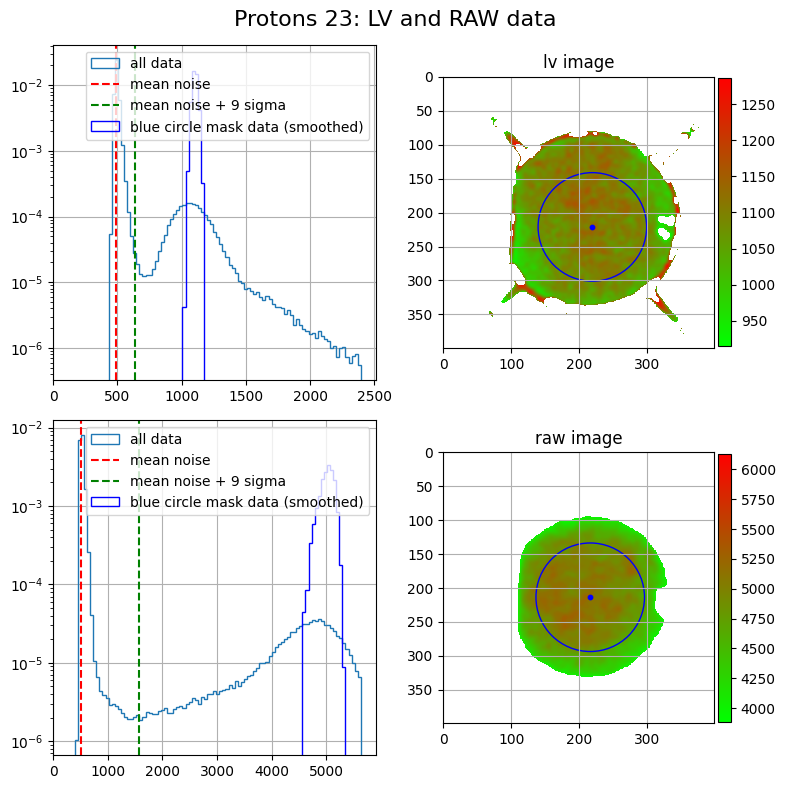

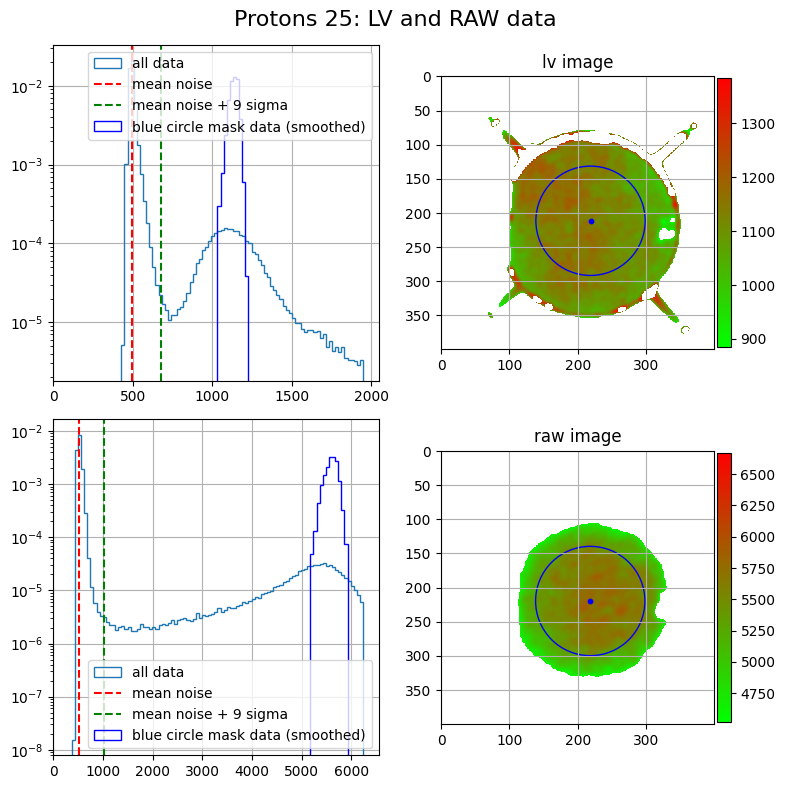

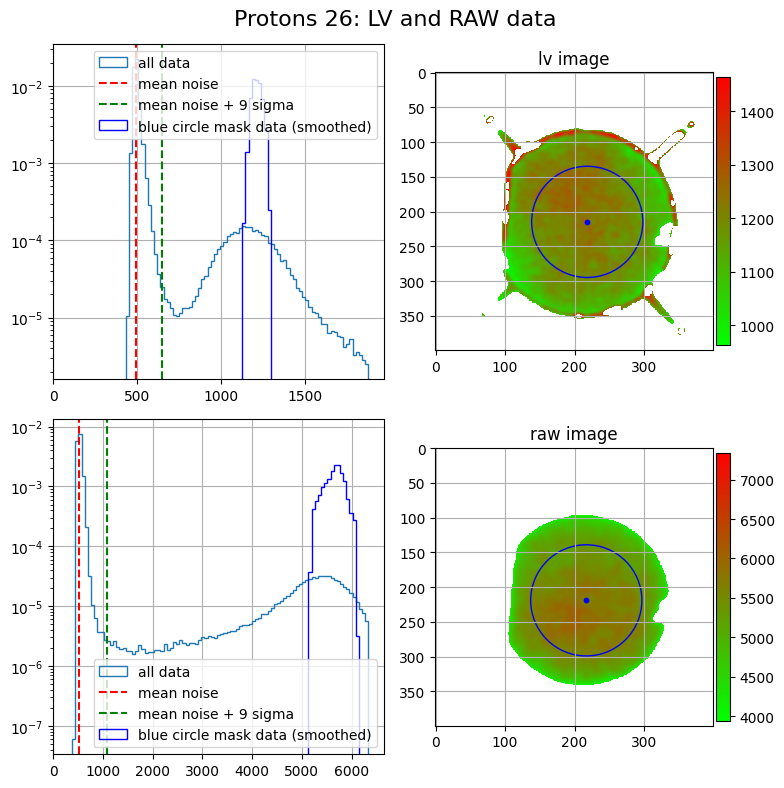

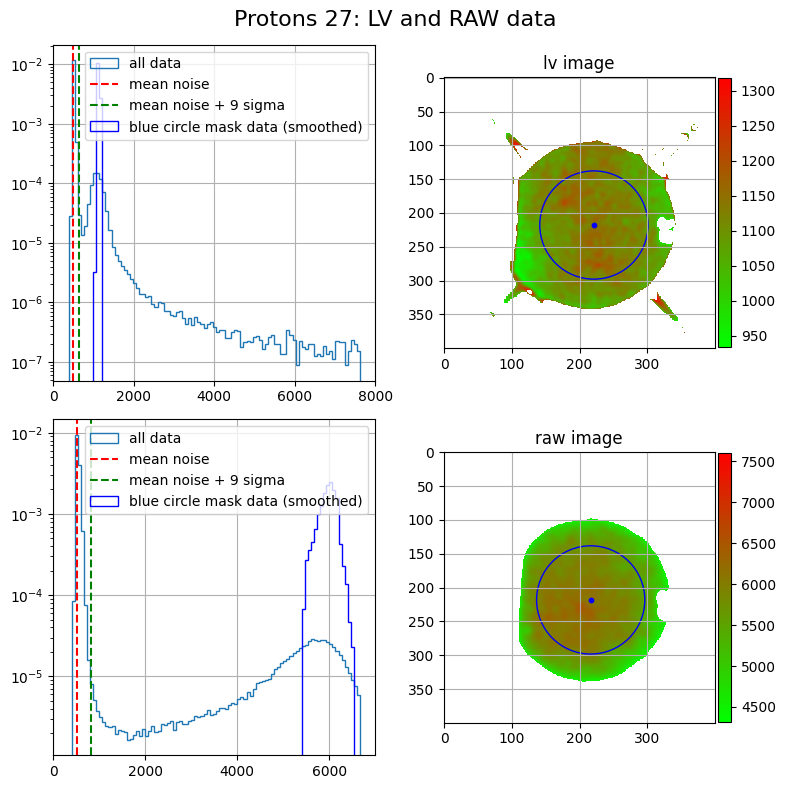

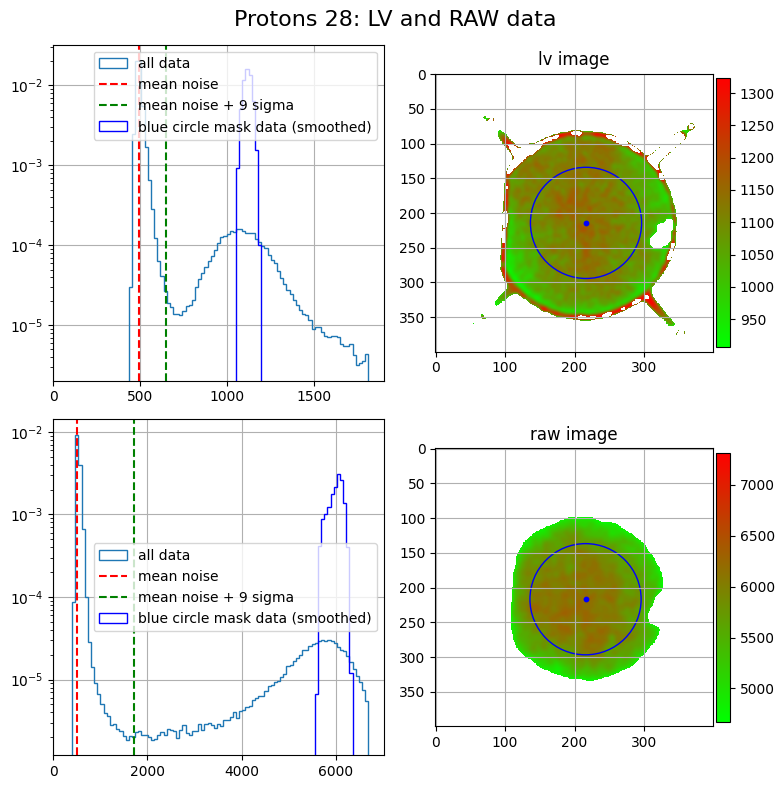

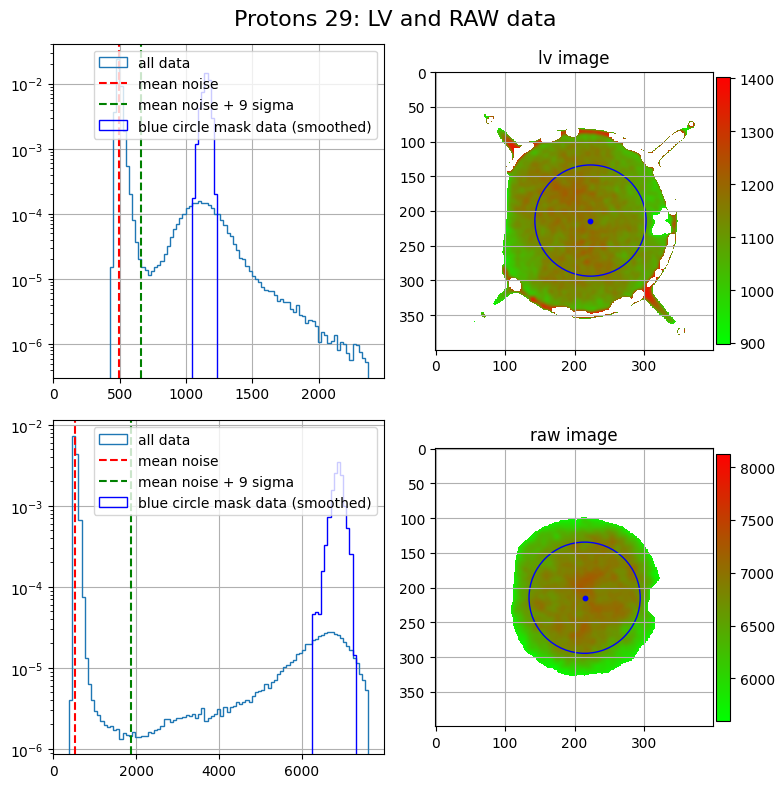

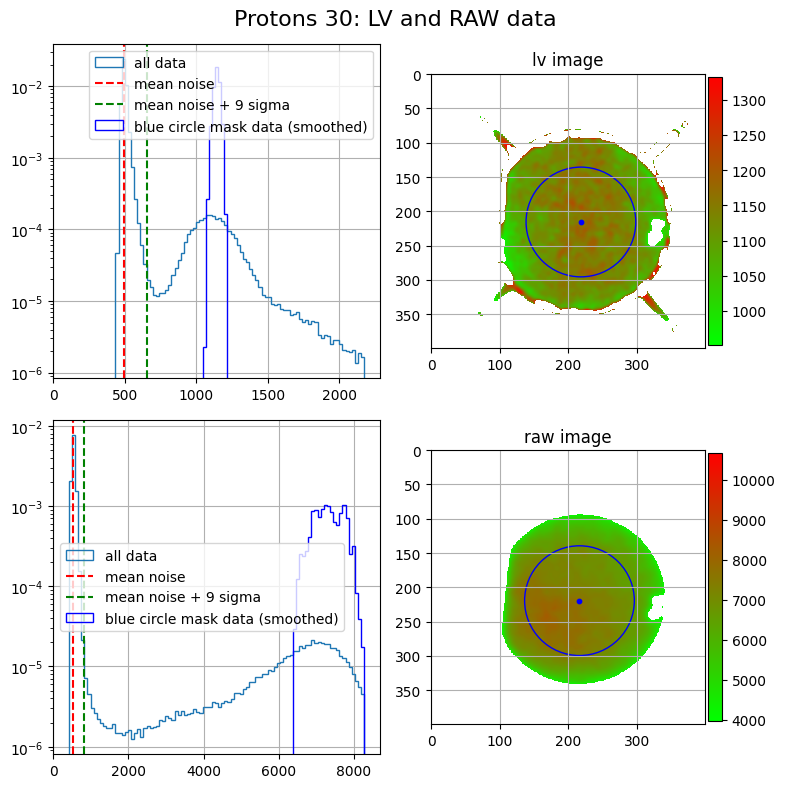

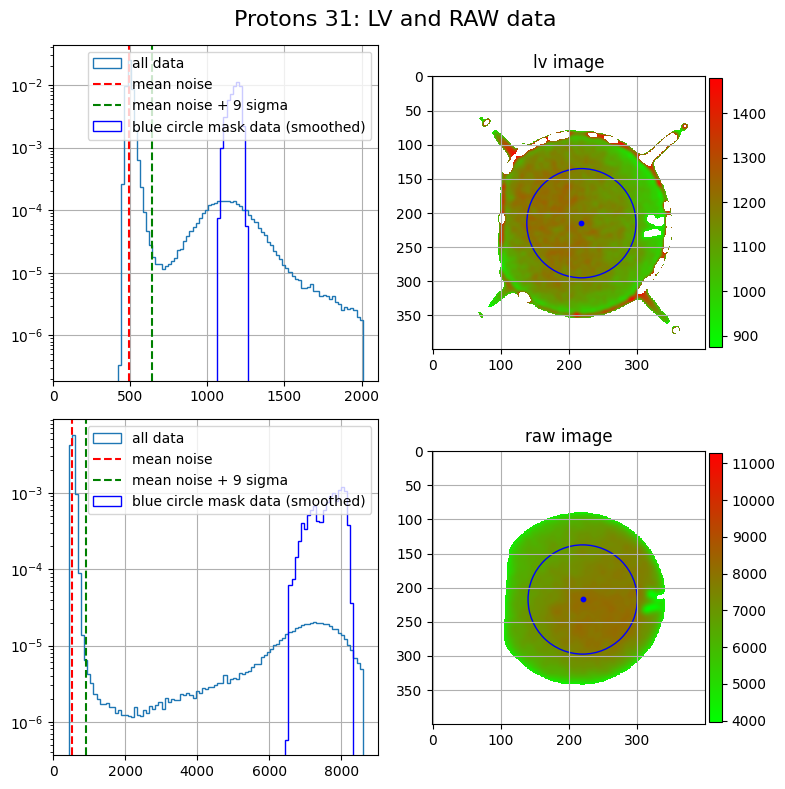

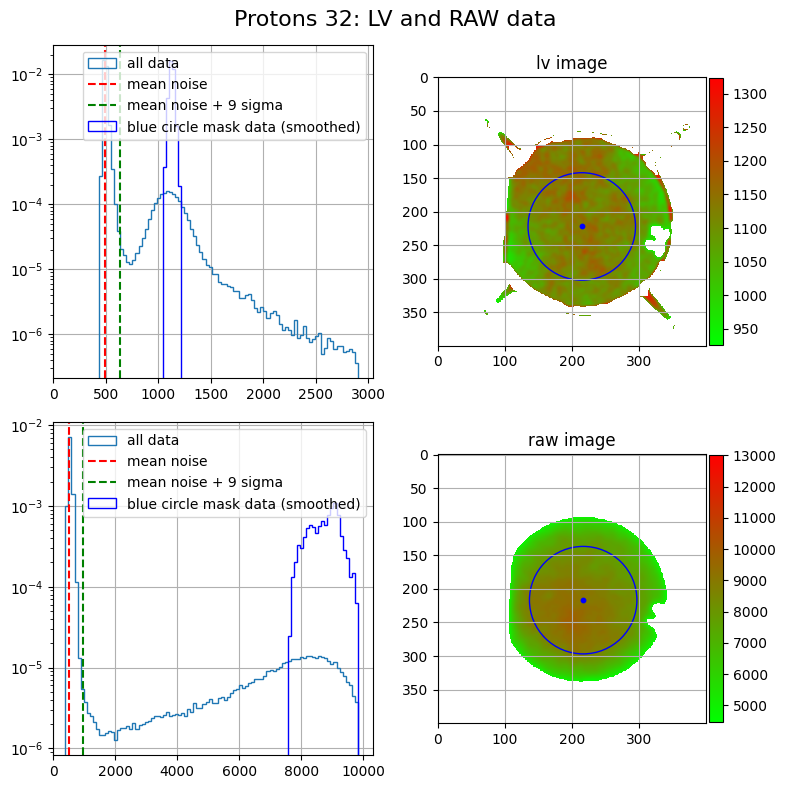

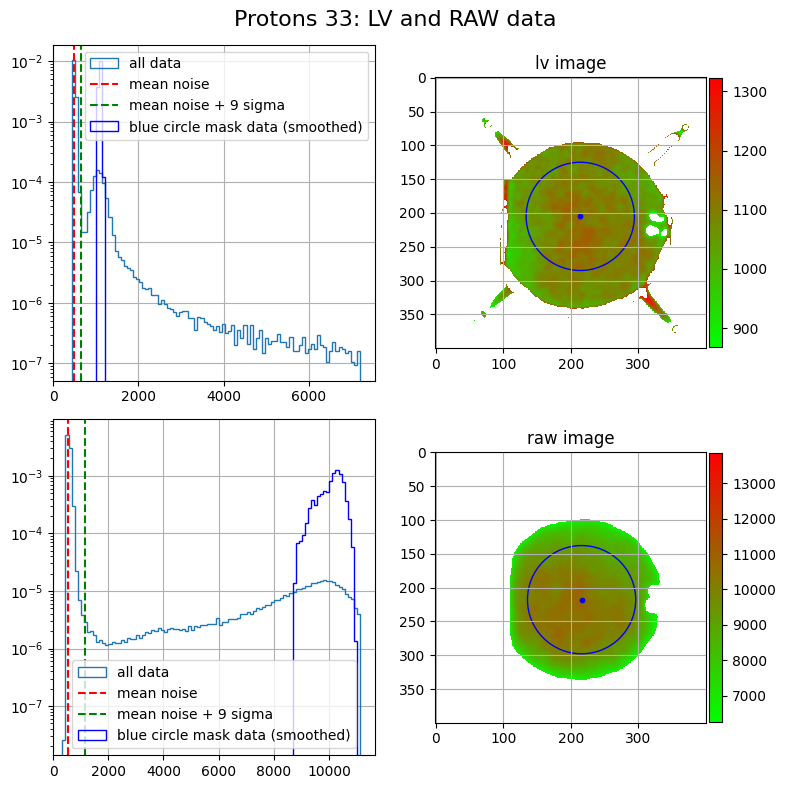

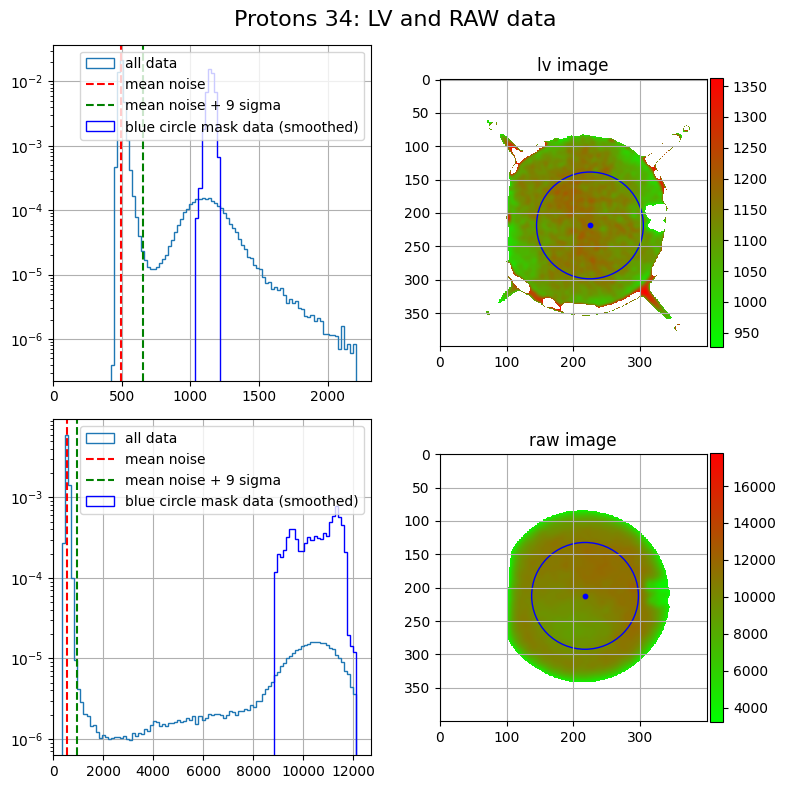

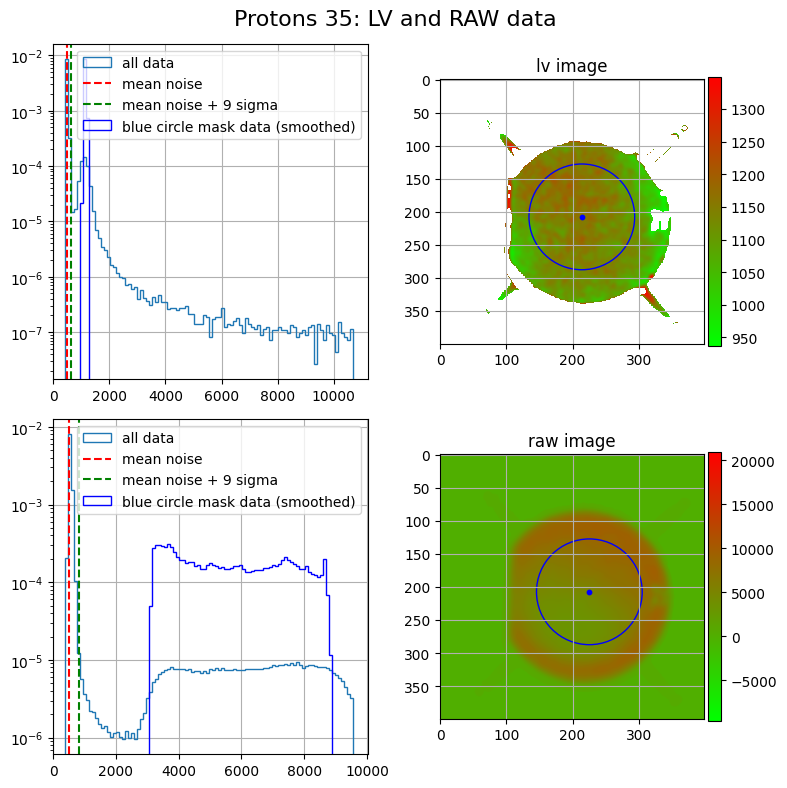

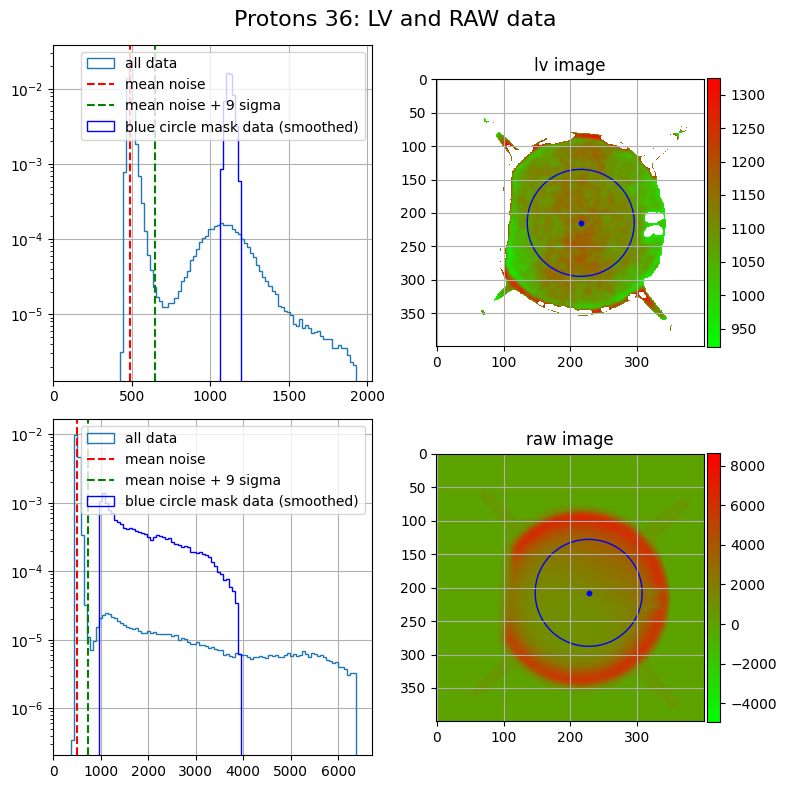

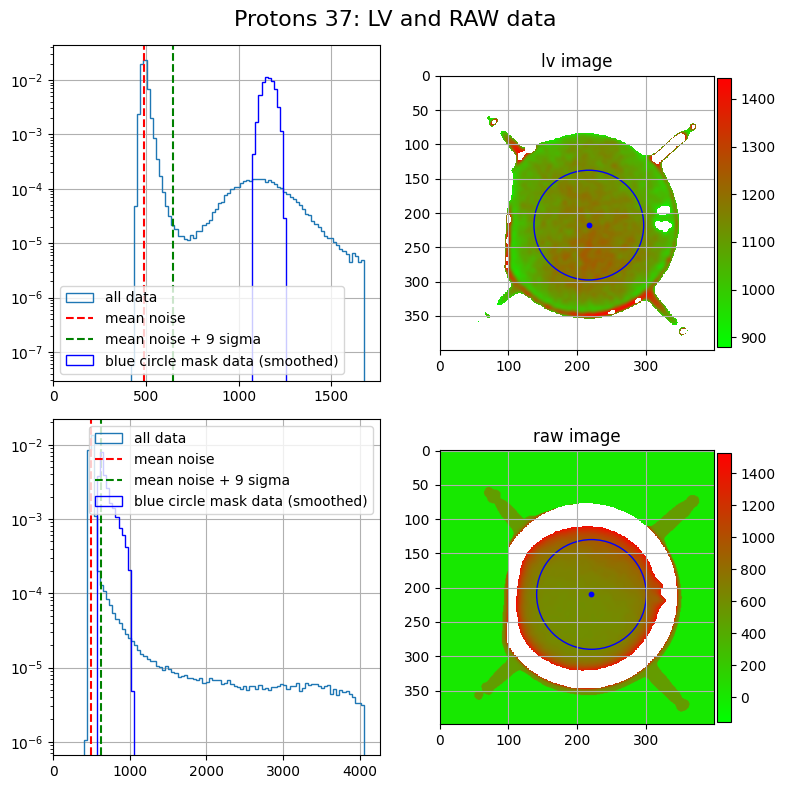

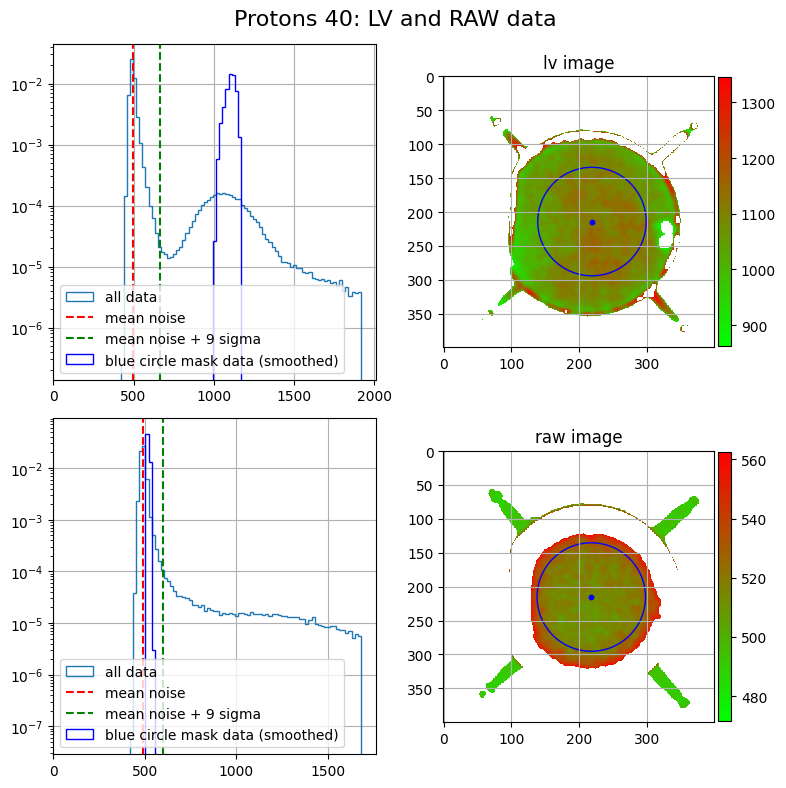

In [16]:
for proton_det_id in sorted(proton_raw_data.data.keys()):
    plot_lv_raw_and_histograms(
        lv_image=proton_raw_data.data[proton_det_id].lv.image.copy(),
        raw_data=proton_raw_data.data[proton_det_id].raw.image.copy(),
        title=f'Protons {proton_det_id}: LV and RAW data',
        probe_radius=80,
        gaussian_kernel_size=3,
        n_sigma=9,
        clip_percentile=99.9,
    )